In [1]:
#!{sys.executable} -m pip install salib
#!{sys.executable} -m pip install epimodels
#!{sys.executable} -m pip install seaborn

In [2]:
%display typeset

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from epimodels.continuous import models as cm
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as plt
from collections import OrderedDict

In [4]:
class SEIRD(cm.ContinuousModel):
    def __init__(self):
        super().__init__()
        self.state_variables = OrderedDict({'S': 'Susceptible', 'E': 'Exposed', 'I': 'Infectious', 'R': 'Removed', 'D': 'Dead'})
        self.parameters = OrderedDict({'beta': r'$\beta$', 'alpha': r'$\alpha$', 'T': r'$T$', 'f': r'$f$', 'N': r'$N$'})
        self.model_type = 'SEIRD'

    def _model(self, t: float, y: list, params: list):
        S, E, I, R, D = y
        beta, alpha, T, f, N = params['beta'], params['alpha'], params['T'], params['f'], params['N']
        return [
            -beta * S * I / N,
            beta * S * I / N - alpha * E,
            alpha * E - 1/T * I,
            (1-f)/T * I,
            f/T*I
        ]

In [5]:
my_model = cm.SEIR()

In [6]:
my_model.parameters

OrderedDict([('beta', '$\\beta$'), ('gamma', '$\\gamma$'), ('epsilon', '$\\epsilon$')])

In [7]:
params = {
    'beta': 0.5,
    'gamma': 0.5,
    'epsilon': 0.2,
    #'f': 0.8,
    #'N': 100,
}
inits = [0.8, 0.2, 0, 0]#, 0]

In [8]:
%%timeit
# parms = dict(zip(params.keys(),param_values[3]))
my_model(inits=inits, trange = [0,200], totpop=1, params=params)
# max(my_model.traces['I'])

10 loops, best of 5: 32.2 ms per loop


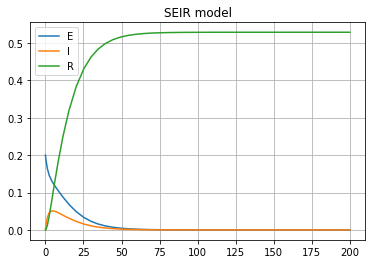

In [9]:

my_model.plot_traces(['I','E', 'R'])

In [10]:
problem = {
    'num_vars': 3,
    'names': list(params.keys()),
    'bounds': [[0.01,0.99], [0.01,0.99], [0.01,0.99]]
}

In [11]:
param_values = saltelli.sample(problem, 1000)

In [12]:
param_values.shape

(8000, 3)

In [13]:
def eval_model(parametros):
    parms = dict(zip(params.keys(),parametros))
    mod = cm.SEIR()
    mod(inits=inits, trange = [0,200], totpop=1, params=parms)
    Y = max(mod.traces['I'])
    return Y

In [14]:
 #Y = np.zeros([param_values.shape[0]])
 #for i, p in enumerate(param_values):
 #    Y[i] = eval_model(p)

In [19]:
from multiprocessing import Pool

In [20]:
Po = Pool()
Y = Po.map(eval_model, param_values)

In [16]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

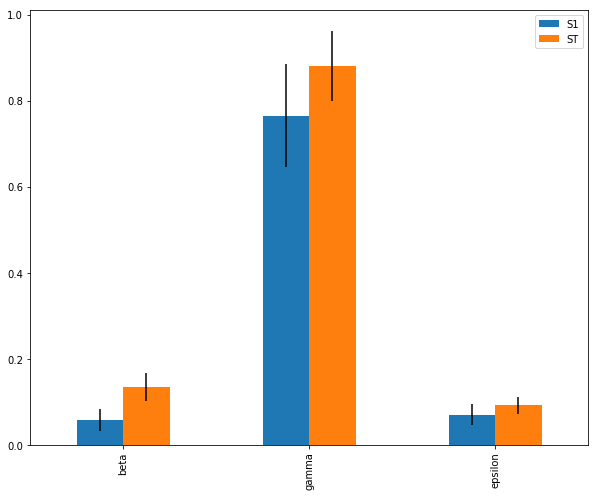

In [21]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'][:-1])
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
plot_sobol(Si,problem)